In [1]:
from random import randint
import pandas as pd
import networkx as nx
import numpy as np
from density import density_g
from similarity import similarity_f
import scipy.interpolate as inter
from skimage.transform import resize
import matplotlib.pyplot as plt 


In [33]:
def similarity_f(structure, vertices, hic_map):
    '''
    :param structure: list of vertices' ids representing generated structure
    :param vertices: df with info about vertices
    :param hic_map: numpy array
    :return: pearson correlation between inversed distance matrix of the structure and hic_map
    '''
    n = len(structure)
    distance_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            a = np.array([vertices[vertices['id'] == structure[i]]['x'],
                         vertices[vertices['id'] == structure[i]]['y'],
                         vertices[vertices['id'] == structure[i]]['z']])
            b = np.array([vertices[vertices['id'] == structure[j]]['x'],
                         vertices[vertices['id'] == structure[j]]['y'],
                         vertices[vertices['id'] == structure[j]]['z']])
            distance_matrix[i, j] = np.sqrt(np.sum((a-b)**2))

    if distance_matrix.shape[0] < hic_map.shape[0]:
        vals = np.reshape(distance_matrix, distance_matrix.size)
        pts = np.array([[i, j] for i in range(n) for j in range(n)])
        grid_x, grid_y = np.mgrid[0:1:hic_map.shape[0] * 1j, 0:1:hic_map.shape[0] * 1j]
        distance_matrix = inter.griddata(pts, vals, (grid_x, grid_y), method='linear')

    elif distance_matrix.shape[0] > hic_map.shape[0]:
        distance_matrix = resize(distance_matrix, (30, 30), mode='constant')

    #distance_matrix = np.linalg.inv(distance_matrix)
    pearson = np.corrcoef(distance_matrix, hic_map)[0, 1]
    return 1-pearson


In [3]:
def create_graph(edges, vertices):
    '''
    :param edges: df with info about edges
    :param vertices: df with info about vertices
    :return: networkx graph
    '''
    graph = nx.Graph()
    graph.add_nodes_from(vertices['id'].tolist())
    graph.add_edges_from([(edges['id1'][i], edges['id2'][i]) for i in range(len(edges))])
    return graph

In [4]:
def read_files(graph_nr, hic_size):
    '''
    :param graph_nr: number of graph to load its vertices and edges
    :param hic_size: size of hic map to load
    :return: df edges, df vertices and numpy array hic_map
    '''
    edges = pd.read_csv(f'data/WB_mesh/d{graph_nr}_E.csv')
    vertices = pd.read_csv(f'data/WB_mesh/d{graph_nr}_V.csv')

    if hic_size not in [20, 30, 50, 100, 150, 207]:
        hic_size = 50
    if hic_size < 100:
        hic_size = f'0{hic_size}'
    hic_map = np.load(f'data/hic/hic_{hic_size}.npy')

    return edges, vertices, hic_map

In [5]:
def add_to_first_node(graph,structure):
    connected_edges = list(graph.edges(structure[0]))
    if (len(connected_edges) == 0):
        return add_to_first_node(graph, remove_first_node(structure))

    connected_edges_1 = []
    for edge in connected_edges:
        if edge[1] not in structure:
            connected_edges_1.append([edge[1]])
    if len(connected_edges_1) == 0:
        return add_to_first_node(graph, remove_first_node(structure))
    a = randint(0, len(list(connected_edges_1)) - 1)
    structure = connected_edges_1[a] + structure
    return structure

In [6]:
def add_to_last_node(graph,structure):
    connected_edges = list(graph.edges(structure[len(structure) - 1]))
    if(len(connected_edges)==0):
        return add_to_last_node(graph,remove_last_node(structure))

    connected_edges_1=[]
    for edge in connected_edges:
        if edge[1] not in structure:
            connected_edges_1.append([edge[1]])
    if len(connected_edges_1)==0:
       return add_to_last_node(graph, remove_last_node(structure))
    a = randint(0, len(list(connected_edges_1)) - 1)
    structure = structure+connected_edges_1[a]
    return structure

In [7]:
def remove_last_node(structure):
    structure = structure[1:]
    return structure

def remove_first_node(structure):
    structure=structure[:len(structure) - 1]
    return structure

def initialize_structure(graph):
    a = randint(0, len(graph.edges) - 1)
    structure = [list(graph.edges)[a][0], list(graph.edges)[a][1]]
    return structure

In [8]:
def probability(structure,graph,vertices,hic_map):

    structure_new=add_to_last_node(graph,structure)

    f_x = similarity_f(structure, vertices, hic_map)
    f_y = similarity_f(structure_new, vertices, hic_map)
    if (f_y / f_x > np.random.uniform()):
        structure = structure_new

    structure_new=add_to_first_node(graph,structure)
    f_x = similarity_f(structure, vertices, hic_map)
    f_y = similarity_f(structure_new, vertices, hic_map)

    if (f_y / f_x > np.random.uniform()):
        structure = structure_new

    return structure


In [11]:
def metropolis(graph,vertices,hic_map,iter):
    structure=initialize_structure(graph)
    tab=[]
    for i in range(iter):
        structure=probability(structure,graph,vertices,hic_map)
        tab.append(similarity_f(structure, vertices, hic_map))
        if(i%5==0):
            print(similarity_f(structure, vertices, hic_map))

    return structure,tab

In [17]:
edges, vertices, hic_map = read_files(8, 20)
g = create_graph(edges, vertices)
structure,tab = metropolis(g,vertices,hic_map,100)


0.002585096956942201
0.002585096956942312
0.5271890820299185
0.4939451230574837
0.038048151398032526
0.08496856364324679
0.18278584924459096
0.15439796543755735
0.06426429050685012
0.3512327923962153
0.08951644518162183
0.11040552811067494
0.05268099346897015
0.7716276135191162
0.5121201464353877
0.2526050595399354
0.04827019705217617
0.058032899586009656
0.06662849748288224
0.04827019705217617


In [32]:
edges, vertices, hic_map = read_files(10, 30)
g = create_graph(edges, vertices)
structure,tab = metropolis(g,vertices,hic_map,100)

0.00258509695694209
0.00258509695694209
0.13144326683593344
0.060375716785651345
0.06401885593590706
0.04024787268301455
0.015996465285933237
0.12700022197881333
0.2524348882196217
0.09681801095828657
0.0372823316187747
0.04114997270594989
0.012142802098585648
0.002585096956942201
0.03717911464809387
0.018315490169084847
0.08122139264043138
0.05016330514496026
0.08910748125321533
0.07027000356326574


Text(0, 0.5, 'Korelacja z oryginalną strukturą')

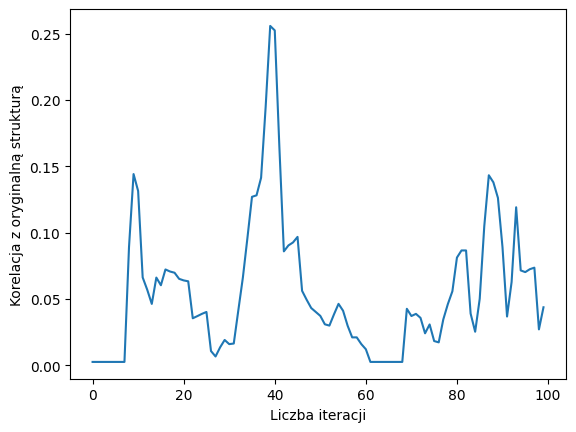

In [34]:
#hic 30 , graph 10
plt.plot(tab)
plt.xlabel('Liczba iteracji')
plt.ylabel('Korelacja z oryginalną strukturą')

Text(0, 0.5, 'Korelacja z oryginalną strukturą')

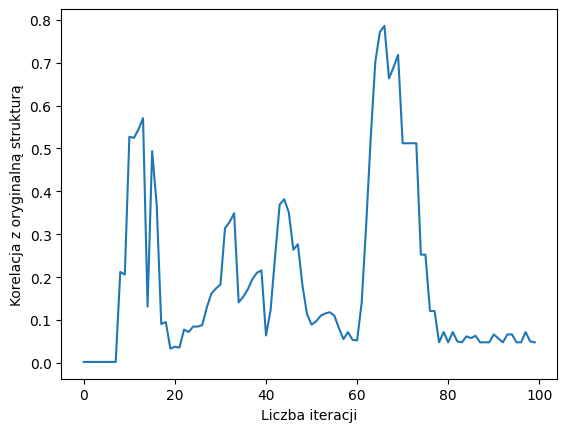

In [19]:
#hic 20 , graph 8
plt.plot(tab)
plt.xlabel('Liczba iteracji')
plt.ylabel('Korelacja z oryginalną strukturą')

Text(0, 0.5, 'Korelacja z oryginalną strukturą')

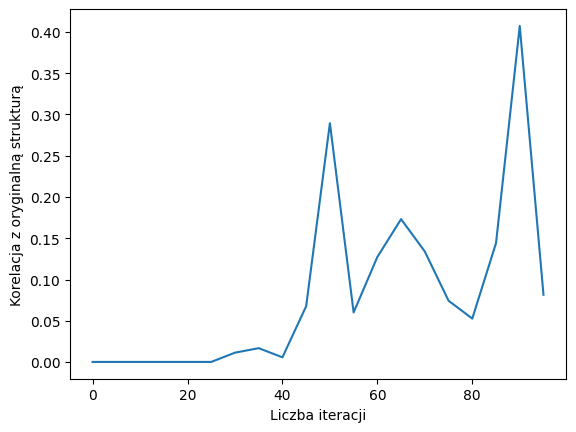

In [34]:
#hic 50 , graph 8
plt.plot(x,tab)
plt.xlabel('Liczba iteracji')
plt.ylabel('Korelacja z oryginalną strukturą')